In [20]:
%load_ext autoreload
%autoreload 2 

In [ ]:
import utils.stocks as stock

ALL_STOCKS = stock.DJIA_STOCK_LIST

In [ ]:
import utils.loader as loader

# The following functions download raw stock data and compute indicators.
# ⚠️ Data has already been prepared, so you do NOT need to rerun them.
# If you want to test these functions, please configure your API key 
# in the environment variables before running.

loader.store_all_ticker(ALL_STOCKS)
loader.calculate_indicators_all(ALL_STOCKS)

In [ ]:
# This function constructs the full dataset for modeling:
# 1. Computes news sentiment scores from financial text
# 2. Applies indicator filtering and feature selection
# 3. Normalizes numerical features for training

full_df, stock_encoder, scaler = loader.construct_all_stocks()

In [ ]:
# Split dataset into train / validation / test sets
# Training:     up to 2023-12-05
# Validation:   2023-12-06 ~ 2024-05-03
# Test:         2024-05-04 ~ 2025-01-01
# WINDOW_SIZE = 30 means models use the past 30 days as input window

train_end = "2023-12-05"
val_end = "2024-05-03"
test_end = "2025-01-01"
WINDOW_SIZE = 30

train_df = full_df[full_df["date"] <= train_end]
val_df = full_df[(full_df["date"] > train_end) & (full_df["date"] <= val_end)]
test_df = full_df[(full_df["date"] > val_end) & (full_df["date"] <= test_end)]

In [ ]:
train_loader = loader.prepare_dataloader(train_df, window=WINDOW_SIZE, shuffle=False)
val_loader = loader.prepare_dataloader(val_df, window=WINDOW_SIZE, shuffle=False)

/home/haiyao/kefan_workspace/Big_Data/utils/loader.py:444: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X = torch.tensor(X, dtype=torch.float32)


In [74]:
import model.models as models

# 1D-CNN

In [ ]:
# Initialize 1D-CNN model
# - input_dim = 8 features per stock (technical indicators, sentiment, etc.)
# - stock_num = 30 (number of stocks considered per batch)
# - kernel_size = 5 (convolution window size)
# - conv_out_channels = 64 (number of output filters in CNN layer)

model_cnn = models.StockCNNOneHot(input_dim=8, stock_num=30, kernel_size=5, conv_out_channels=64)
models.train_model(model_cnn, train_loader, val_loader, epochs=40)

In [30]:
import utils.evaluator as evaluator
import pandas as pd

In [ ]:
# Construct a portfolio by selecting the top-5 stocks each day based on predicted returns
# - Equal-weight allocation across the selected stocks

pred_df_cnn = models.predict_returns(model_cnn, full_df)

portfolio_df_cnn_top_5 = evaluator.compute_returns(pred_df_cnn, full_df, 5)
evaluator.evaluate_portfolio(portfolio_df_cnn_top_5)

📊 Portfolio Performance
📈 Accumulated Return (AR): 28.87%
💡 Sharpe Ratio (SR): 3.7657
📉 Calmar Ratio (CR): 9.5554

📊 Equal-Weight Benchmark
📈 Accumulated Return (AR): 14.61%
💡 Sharpe Ratio (SR): 2.1086
📉 Calmar Ratio (CR): 4.5661


In [ ]:
# Construct a portfolio by selecting the top-10 stocks

portfolio_df_cnn_top_10 = evaluator.compute_returns(pred_df_cnn, full_df, 10)
evaluator.evaluate_portfolio(portfolio_df_cnn_top_10, compare = False)

📊 Portfolio Performance
📈 Accumulated Return (AR): 23.62%
💡 Sharpe Ratio (SR): 1.6381
📉 Calmar Ratio (CR): 3.6212


In [ ]:
# Construct a portfolio by selecting the top-1 stocks

portfolio_df_cnn_top_1 = evaluator.compute_returns(pred_df_cnn, full_df, 1)
evaluator.evaluate_portfolio(portfolio_df_cnn_top_1, compare = False)

📊 Portfolio Performance
📈 Accumulated Return (AR): 19.08%
💡 Sharpe Ratio (SR): 1.8506
📉 Calmar Ratio (CR): 5.6331


# LSTM

In [76]:
# Initialize an LSTM-based stock prediction model
# Parameters:
# - input_dim=8: number of input features per time step (technical indicators, sentiment, etc.)
# - hidden_dim=32: dimensionality of the hidden state in LSTM
# - stock_num=30: number of unique stocks (used for embedding)
# - emb_dim=8: embedding dimension for stock IDs
# - num_layers=2: number of stacked LSTM layers for capturing deeper temporal dependencies

model_lstm = models.StockLSTM(input_dim=8, hidden_dim=32, stock_num=30, emb_dim=8, num_layers=2)
models.train_model(model_lstm, train_loader, val_loader, epochs=40)

In [ ]:
# Construct a portfolio by selecting the top-5 stocks each day based on predicted returns
# - Equal-weight allocation across the selected stocks

pred_df_lstm = models.predict_returns(model_lstm, full_df)

portfolio_df_lstm_top_5 = evaluator.compute_returns(pred_df_lstm, full_df, 5)
evaluator.evaluate_portfolio(portfolio_df_lstm_top_5)

📊 Portfolio Performance
📈 Accumulated Return (AR): 26.07%
💡 Sharpe Ratio (SR): 2.9347
📉 Calmar Ratio (CR): 6.3056

📊 Equal-Weight Benchmark
📈 Accumulated Return (AR): 14.61%
💡 Sharpe Ratio (SR): 2.1086
📉 Calmar Ratio (CR): 4.5661


In [ ]:
# Construct a portfolio by selecting the top-10 stocks

portfolio_df_lstm_top_10 = evaluator.compute_returns(pred_df_lstm, full_df, 10)
evaluator.evaluate_portfolio(portfolio_df_lstm_top_10, compare = False)

📊 Portfolio Performance
📈 Accumulated Return (AR): 20.17%
💡 Sharpe Ratio (SR): 2.6153
📉 Calmar Ratio (CR): 6.6062


In [ ]:
# Construct a portfolio by selecting the top-1 stocks

portfolio_df_lstm_top_1 = evaluator.compute_returns(pred_df_lstm, full_df, 1)
evaluator.evaluate_portfolio(portfolio_df_lstm_top_1, compare = False)

📊 Portfolio Performance
📈 Accumulated Return (AR): 24.69%
💡 Sharpe Ratio (SR): 1.1781
📉 Calmar Ratio (CR): 2.4055


# Transformer

In [ ]:
# Initialize a Transformer-based stock prediction model
# Parameters:
# - input_dim=8: number of input features per time step (technical indicators, sentiment, etc.)
# - stock_num=30: number of unique stocks (used for embedding)
# - emb_dim=8: embedding dimension for stock IDs
# - d_model=64: hidden dimension of the Transformer model
# - nhead=4: number of attention heads in the multi-head attention layer
# - num_layers=2: number of stacked Transformer encoder layers

model_tr = models.StockTransformer(
    input_dim=8, stock_num=30, emb_dim=8, d_model=64, nhead=4, num_layers=2
)
models.train_model(model_tr, train_loader, val_loader, epochs=80)

In [ ]:
# Construct a portfolio by selecting the top-5 stocks

pred_df_tr = models.predict_returns(model_tr, full_df)

portfolio_df_tr_top_5 = evaluator.compute_returns(pred_df_tr, full_df, 5)
evaluator.evaluate_portfolio(portfolio_df_tr_top_5)

📊 Portfolio Performance
📈 Accumulated Return (AR): 17.80%
💡 Sharpe Ratio (SR): 1.5727
📉 Calmar Ratio (CR): 2.6287

📊 Equal-Weight Benchmark
📈 Accumulated Return (AR): 14.61%
💡 Sharpe Ratio (SR): 2.1086
📉 Calmar Ratio (CR): 4.5661


In [ ]:
# Construct a portfolio by selecting the top-10 stocks

portfolio_df_tr_top_10 = evaluator.compute_returns(pred_df_tr, full_df, 10)
evaluator.evaluate_portfolio(portfolio_df_tr_top_10)

📊 Portfolio Performance
📈 Accumulated Return (AR): 16.20%
💡 Sharpe Ratio (SR): 1.8623
📉 Calmar Ratio (CR): 3.5734

📊 Equal-Weight Benchmark
📈 Accumulated Return (AR): 14.61%
💡 Sharpe Ratio (SR): 2.1086
📉 Calmar Ratio (CR): 4.5661


In [ ]:
# Construct a portfolio by selecting the top-1 stocks

portfolio_df_tr_top_1 = evaluator.compute_returns(pred_df_tr, full_df, 1)
evaluator.evaluate_portfolio(portfolio_df_tr_top_1)

📊 Portfolio Performance
📈 Accumulated Return (AR): -0.82%
💡 Sharpe Ratio (SR): -0.0358
📉 Calmar Ratio (CR): -0.0450

📊 Equal-Weight Benchmark
📈 Accumulated Return (AR): 14.61%
💡 Sharpe Ratio (SR): 2.1086
📉 Calmar Ratio (CR): 4.5661


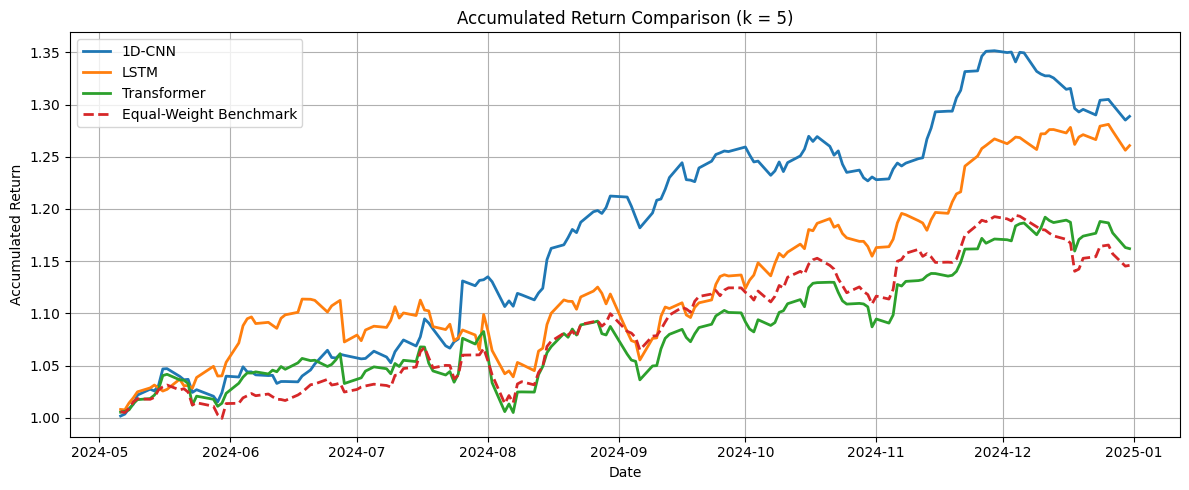

In [70]:
models = {
    "1D-CNN": portfolio_df_cnn_top_5,
    "LSTM": portfolio_df_lstm_top_5,
    "Transformer": portfolio_df_tr_top_5,
}
evaluator.plot_returns_comparison_multi(models, start_date="2024-05-04", end_date="2025-01-01")